# **Khushdev Pandit**
# **Roll no: 2020211** 
# *Assignment Question-2*

#

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import open3d as o3d
import glob

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# **Q2 Part-1**
##### (10 points) Compute the chessboard plane normals nLi, i ∈ {1, . . . , 25} and the corresponding offsets di , i ∈ {1, . . . , 25} using the planar LIDAR points in each of the pcd files. You can estimate these by making use of singular value decomposition.

In [2]:
# Helper functions to load the camera parameters
def load_camera_parameters(camera_matrix_path, distortion_coefficients_path):
    with open(distortion_coefficients_path, 'r') as f:
        contents = f.read()
        distCoeff = contents.split('\n')[:1][0].split(' ')
        distCoeff = np.array(distCoeff, dtype=np.float32)
    return load_matrix(camera_matrix_path), distCoeff

# Load the matrix from the file
def load_matrix(file_path):
    with open(file_path, 'r') as f:
        contents = f.read()
        matrix = contents.split('\n')[:3]
        matrix = [i.split(' ') for i in matrix]
        matrix = np.array(matrix, dtype=np.float32)
    return matrix

# Load the vector from the file
def load_vector(file_path):
    with open(file_path, 'r') as f:
        contents = f.read()
        vector = contents.split('\n')[:3]
        vector = np.array(vector, dtype=np.float32)
    return vector

# Helper functions to load the camera parameters
def load_camera_coord_param_for_image(folder_path):
    camera_normal = load_vector(os.path.join(folder_path, 'camera_normals.txt'))
    rotation_matrix = load_matrix(os.path.join(folder_path, 'rotation_matrix.txt'))
    rotation_vector = load_vector(os.path.join(folder_path, 'rotation_vectors.txt'))
    translation_vector = load_vector(os.path.join(folder_path, 'translation_vectors.txt'))
    return camera_normal, rotation_matrix, rotation_vector, translation_vector

In [3]:
# load all the lidar scans, camera images and camera parameters
lidar_scans = glob.glob('lidar_scans/*.pcd')
camera_images = glob.glob('camera_images/*.jpeg')
camera_coord_param = glob.glob('camera_parameters/*.jpeg')
camera_param = glob.glob('camera_parameters/*.txt')
indices = np.arange(0, len(lidar_scans))
indices = np.random.choice(indices, 25, replace=False)

lidar_scans.sort()
camera_images.sort()
camera_coord_param.sort()

camera_images = np.array(camera_images)[indices]
lidar_scans = np.array(lidar_scans)[indices]
camera_coord_param = np.array(camera_coord_param)[indices]

In [4]:
lidar_plane_normals = []
lidar_plane_offsets = []

# read all the lidar scans and segment the plane
for lidar in lidar_scans:
    pcd = o3d.io.read_point_cloud(lidar)
    plane_model, inliers = pcd.segment_plane(distance_threshold=0.01,
                                            ransac_n=3,
                                            num_iterations=1000)
    
    # extract the plane normal and offset
    normal = plane_model[:3]
    offset = plane_model[3]
    lidar_plane_normals.append(normal)
    lidar_plane_offsets.append(offset)
lidar_plane_normals, lidar_plane_offsets = np.array(lidar_plane_normals), np.array(lidar_plane_offsets)

Load the Lidar plane normal and offsets

In [5]:
# load the lidar plane normals and offsets
lidar_plane_normals = []
lidar_plane_offsets = []

for lidar in lidar_scans:
    pcd = o3d.io.read_point_cloud(lidar)
    plane_model, _ = pcd.segment_plane(distance_threshold=0.01,
                                            ransac_n=3,
                                            num_iterations=1000)
    # Load the lidar points from the point cloud
    lidar_pts = np.asarray(pcd.points)
    # Estimate the center of the all the lidar points
    center = np.mean(lidar_pts, axis=0)
    centered_points = lidar_pts - center
    
    # Perform SVD on the shifted lidar points to estimate the plane normal
    U, S, V = np.linalg.svd(centered_points)

    # Estimate plane normal
    normal = V[-1, :] 
    # Estimate offset of the plane
    offset = np.dot(normal, center)
    lidar_plane_normals.append(normal)
    lidar_plane_offsets.append(offset)
lidar_plane_normals, lidar_plane_offsets = np.array(lidar_plane_normals), np.array(lidar_plane_offsets)

# **Q2 Part-2**
##### (10 points) Now that you have the plane normals nCi and nLi in camera and LIDAR frame of reference respectively for all the selected images, derive the set of equations that you would use to solve for estimating the transformation CTL = [CRL|CtL], i.e. the transformation from the LIDAR frame to the camera frame. Explain how the rotation and translation matrices are calculated. [Hint: You may refer to this thesis (Sec. 5) for deriving the necessary equations.]

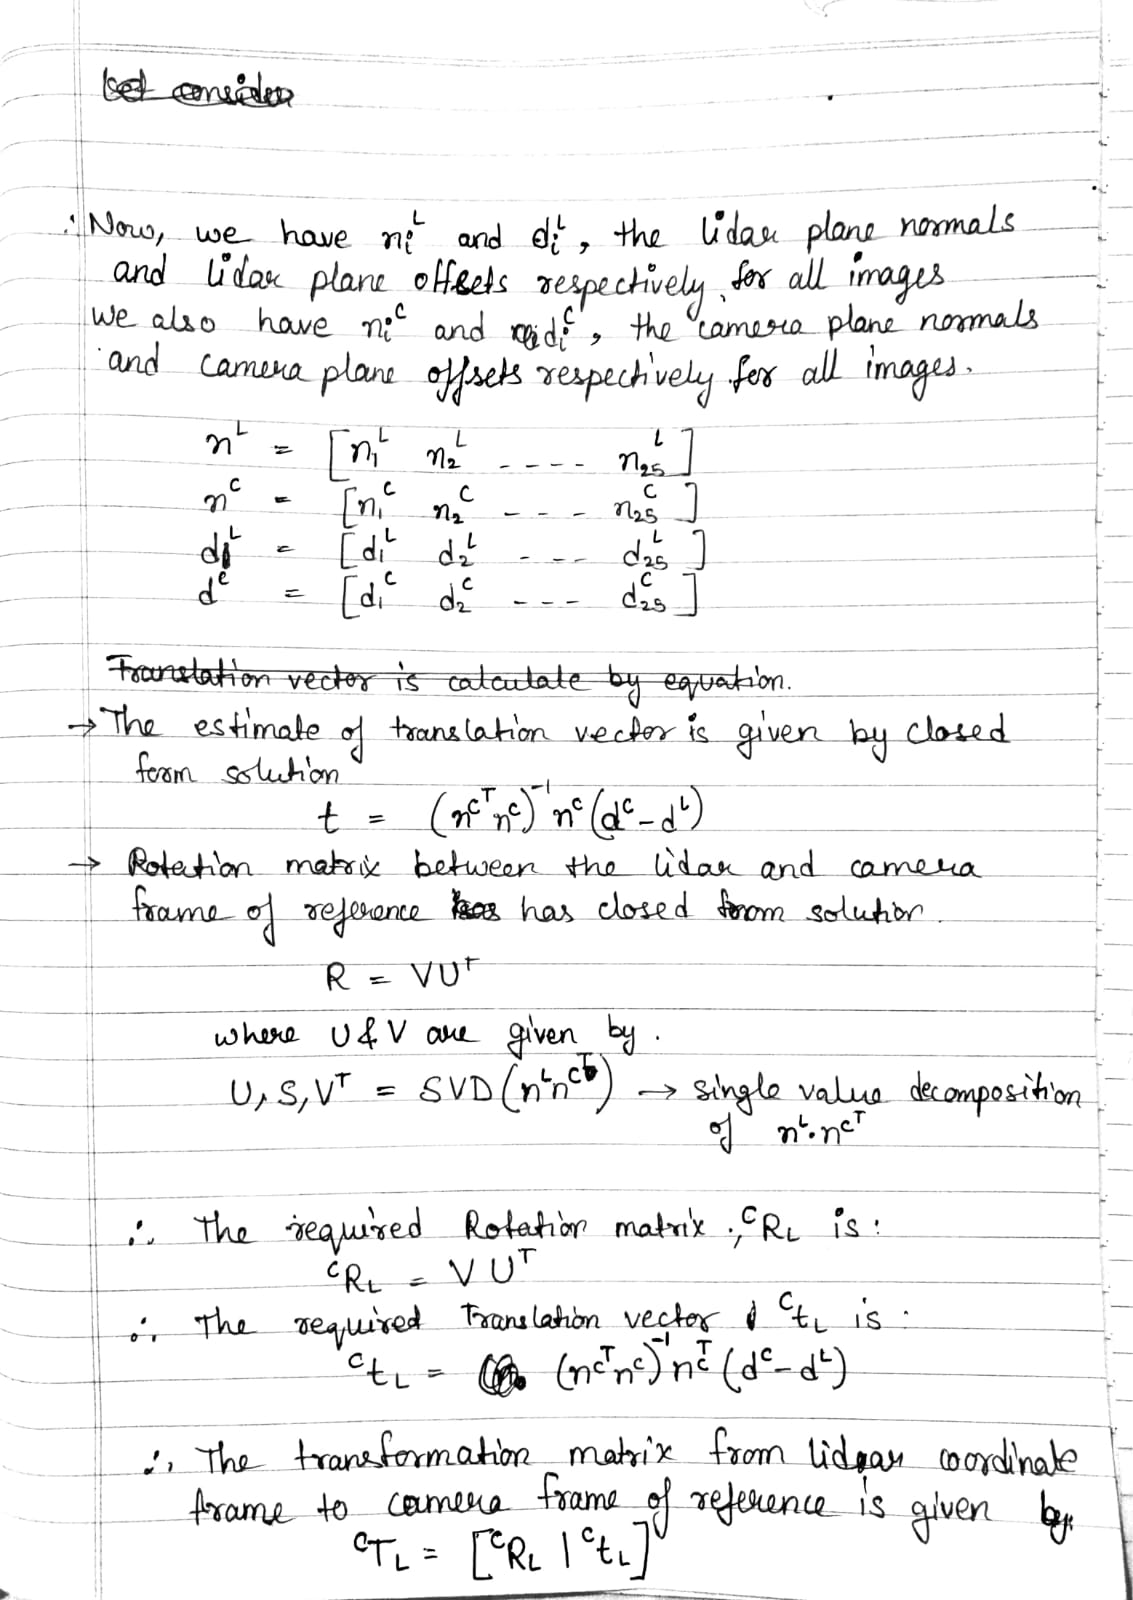

# **Q2 Part-3**
##### (5 points) Using the above equations, implement the function that estimates the transformation CTL. Recall that the rotation matrix has determinant +1.

In [6]:
camera_plane_normals = []
camera_plane_offsets = []

for image in camera_coord_param:
    # camera_normal, rotation_matrix, rotation_vector, translation_vector
    nCi, RCi, rCi, tCi = load_camera_coord_param_for_image(image)
    orientation_ci = nCi            # Orientation (θc,i)
    alpha_ci = np.dot(rCi, tCi)     # Distance (αc,i)
    camera_plane_normals.append(orientation_ci)
    camera_plane_offsets.append(alpha_ci)

camera_plane_normals = np.array(camera_plane_normals)
camera_plane_offsets = np.array(camera_plane_offsets)

In [7]:
def get_lidar_to_camera_transform(lidar_plane_normals, lidar_plane_offsets, 
                                camera_plane_normals, camera_plane_offsets):
    mat1 = np.linalg.inv(np.dot(camera_plane_normals.T, camera_plane_normals))
    mat2 = np.dot(camera_plane_normals.T, (camera_plane_offsets - lidar_plane_offsets))
    
    # SVD of the lidar plane normals and camera plane normals to estimate the rotation matrix    
    U, S, V_T = np.linalg.svd(np.dot(lidar_plane_normals.T, camera_plane_normals))
    
    CtL = np.dot(mat1, mat2)        # Translation vector (t)
    CRL = -np.dot(V_T, U.T)         # Rotation matrix (R)
    
    # Transform matrix from lidar to camera
    CTL = np.hstack((CRL, CtL.reshape(3, 1)))
    return CTL, CRL, CtL

CTL, CRL, CtL = get_lidar_to_camera_transform(lidar_plane_normals, lidar_plane_offsets, camera_plane_normals, camera_plane_offsets)

In [8]:
print('Transform matrix from lidar to camera: \n', CTL)

Transform matrix from lidar to camera: 
 [[  0.09092573   0.97266644  -0.21366447  -3.17521814]
 [  0.55732059  -0.22750868  -0.79851961 -11.47034529]
 [ -0.82530374  -0.04647363  -0.56277343  -6.91501708]]


In [9]:
print('Rotation matrix from lidar to camera: \n', CRL)

Rotation matrix from lidar to camera: 
 [[ 0.09092573  0.97266644 -0.21366447]
 [ 0.55732059 -0.22750868 -0.79851961]
 [-0.82530374 -0.04647363 -0.56277343]]


In [10]:
print('Translation vector from lidar to camera: \n', CtL)

Translation vector from lidar to camera: 
 [ -3.17521814 -11.47034529  -6.91501708]


In [12]:
np.linalg.det(CRL)

1.0000000000000009

# **Q2 Part-4**
##### (5 points) Use the estimated transformation CTe L to map LIDAR points to the camera frame of reference, then project them to the image plane using the intrinsic camera parameters. Are all points within the checkerboard pattern’s boundary in each image?

In [13]:
# Load the Intrinsic and Distortion parameters of the camera
intrinsic_matrix, distCoeff = load_camera_parameters(*camera_param)
camera_intrinsic = np.hstack((intrinsic_matrix, np.zeros((3, 1))))

# Extrinsic parameters of the camera
camera_extrinsic = np.vstack((CTL, np.array([0, 0, 0, 1])))

# Camera projection matrix
camera_projection_matrix = np.dot(camera_intrinsic, camera_extrinsic)

In [14]:
# compute the image points from the lidar points
camera_image_points = []
lidar_image_points = []

for lidar in lidar_scans:
    pcd = o3d.io.read_point_cloud(lidar)
    plane_model, inliers = pcd.segment_plane(distance_threshold=0.01,
                                            ransac_n=3,
                                            num_iterations=1000)
    # Load the lidar points from the point cloud
    lidar_points = np.asarray(pcd.points)
    lidar_points = np.vstack((lidar_points.T, np.ones((1, len(lidar_points))) ))
    # Compute the image points from the lidar points
    camera_points = np.dot(camera_projection_matrix, lidar_points)
    camera_points = camera_points[:2, :] / camera_points[2, :]
    camera_image_points.append(camera_points)
    lidar_image_points.append(lidar_points)

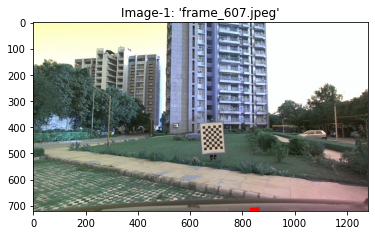

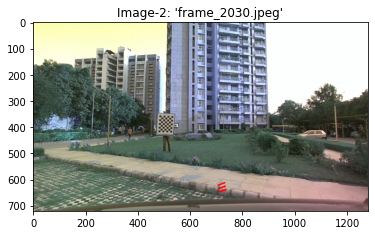

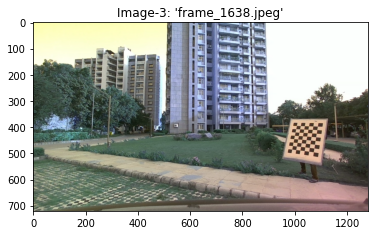

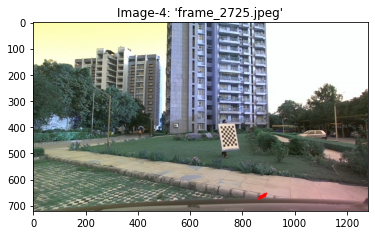

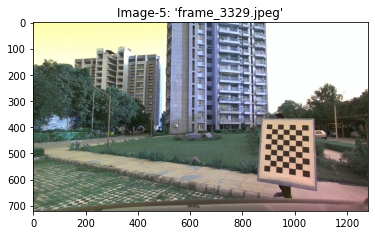

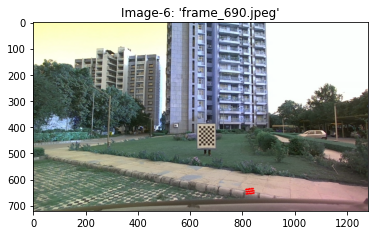

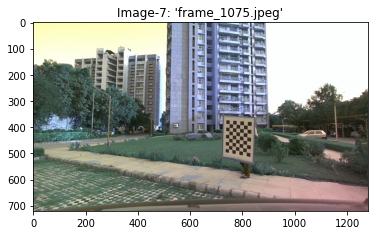

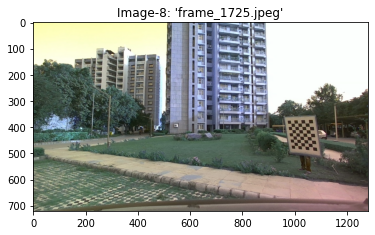

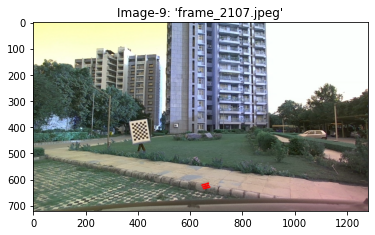

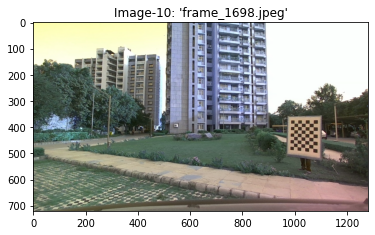

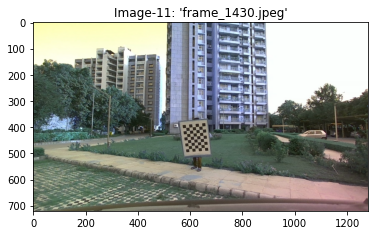

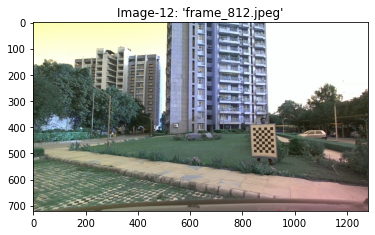

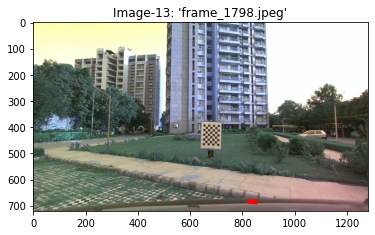

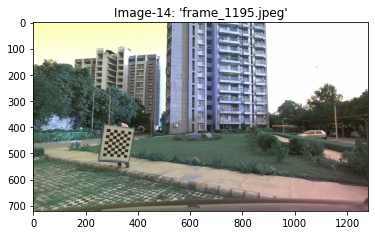

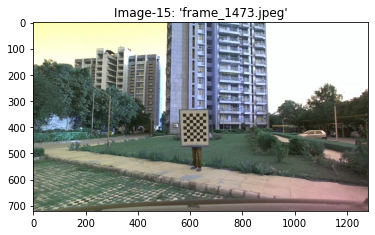

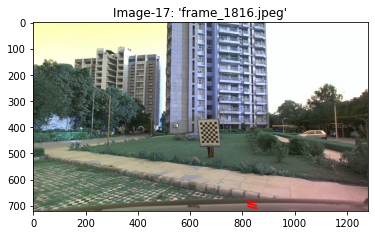

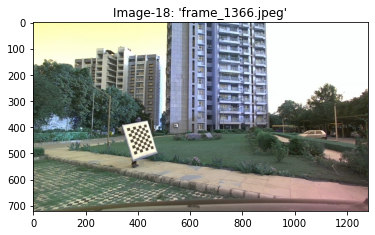

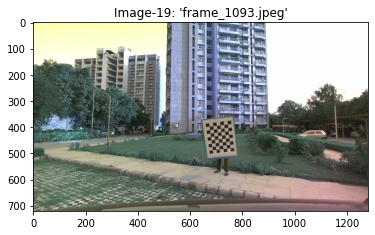

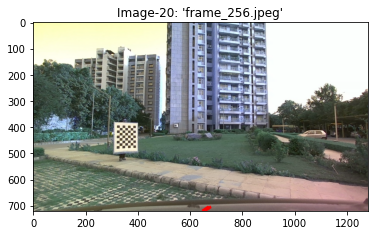

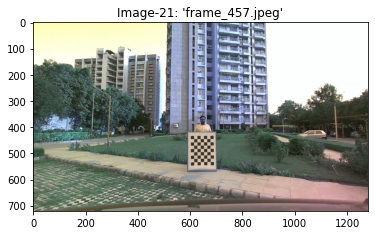

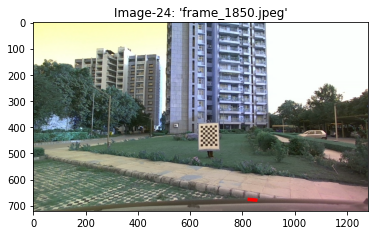

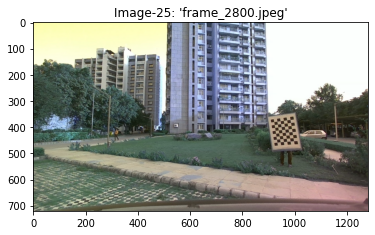

In [15]:
for j, image_name in enumerate(camera_images):
    image = cv2.imread(image_name)
    
    image_points_x = camera_image_points[j][0, :]
    image_points_y = camera_image_points[j][1, :]
    
    for i in range(image_points_x.shape[0]):
        cv2.circle(img=image, center=(int(image_points_x[i]), int(image_points_y[i])), 
                    radius=1, color=(255, 0, 0), thickness=3) 
    plt.imshow(image)
    plt.title(f"Image-{j+1}: '" + image_name.split('\\')[-1] + "'")
    plt.show()

##### Observation: No all points are not within the checkerboard pattern’s boundary in each image

# **Q2 Part-5**
##### (10 points) Plot the normal vectors nL_i, nC_i, CRL_nL_i for any 5 image and LIDAR scan pairs. Compute the cosine distance between the camera normal nCi and the transformed LIDAR normal, CRL_nL_i for all 38 image and LIDAR scan pairs, and plot the histogram of these errors. Report the average error with the standard deviation.

In [16]:
def plot_normal_on_image(image, image_points, normal, color=(0, 0, 255)):
    mean_u = np.median(image_points[0])
    mean_v = np.median(image_points[1])
    
    # calculate z coordinate of the image plane
    z = -(normal[0] * mean_u + normal[1] * mean_v)  / normal[2]

    # calculate end point of line of the normal vector on the image plane
    end_point = 200*np.array([mean_u, mean_v, z])

    # Drawing the normal vector on the image
    image_with_normal = cv2.line(img=image, pt1=(int(mean_u), int(mean_v)), pt2=(int(end_point[0]), int(end_point[1])), 
                                color=color, thickness=5, lineType=8, shift=0)
    return image_with_normal

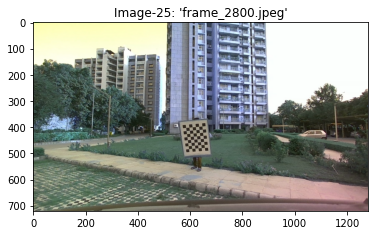

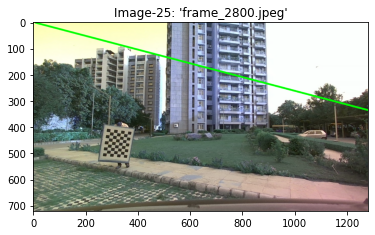

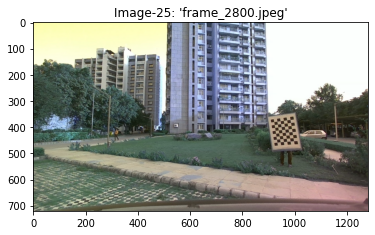

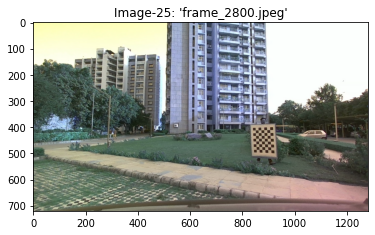

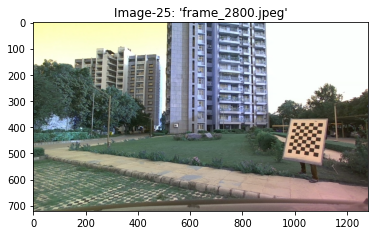

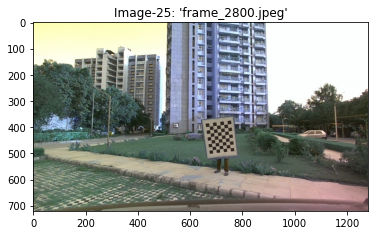

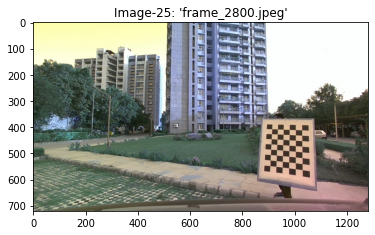

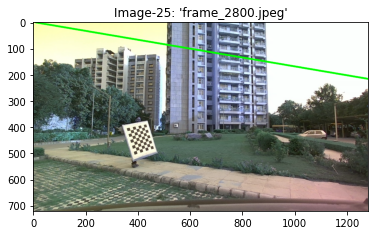

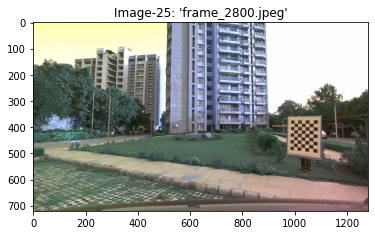

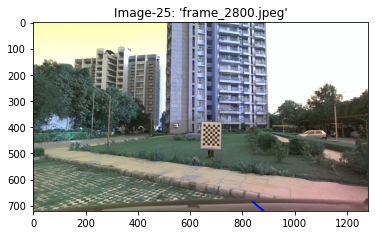

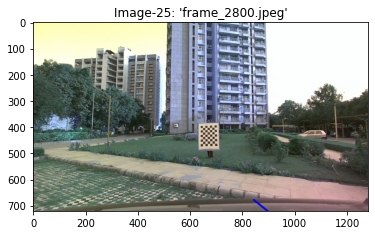

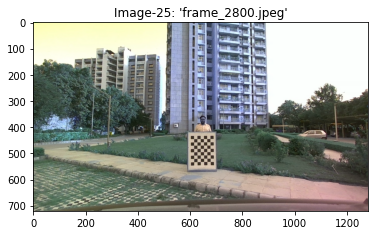

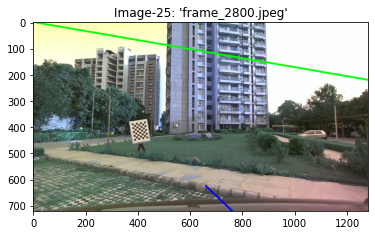

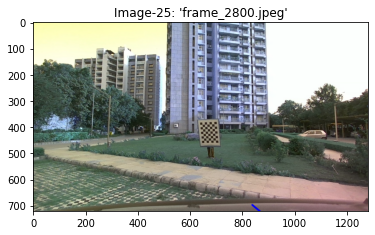

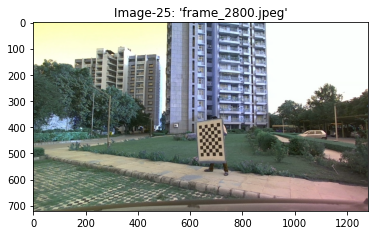

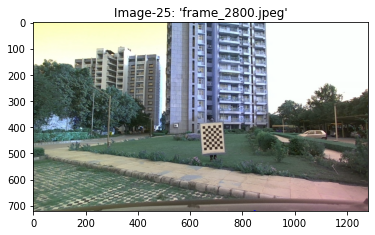

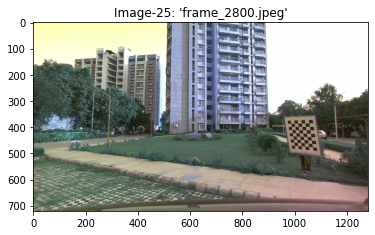

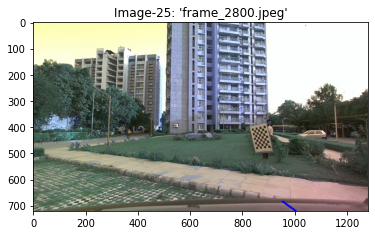

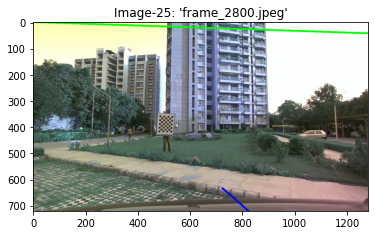

In [17]:
index_5 = np.random.choice(len(camera_images), len(camera_images), replace=False)
transformed_lidar_normals = []

for ind in index_5:
    image = cv2.imread(camera_images[ind])
    lidar_normal = lidar_plane_normals[ind]
    camera_nomral = camera_plane_normals[ind]
    transformed_lidar_normal = np.dot(CRL, lidar_normal)
    camera_points = camera_image_points[ind]
    lidar_points = lidar_image_points[ind] * 1.5
    transformed_lidar_points = np.dot(CTL, lidar_points) * 2
    transformed_lidar_normals.append(transformed_lidar_normal)
    # transformed_lidar_points = np.dot(CRL, lidar_points[:3]) * 2
    
    # Blue color for camera normal
    image_with_normal = plot_normal_on_image(image, camera_points, camera_nomral, color=(0, 0, 255))
    # Green color for lidar normal
    image_with_normal = plot_normal_on_image(image_with_normal, lidar_points, lidar_normal, color=(0, 255, 0))
    # Red color for transformed lidar normal
    image_with_normal = plot_normal_on_image(image_with_normal, transformed_lidar_points, transformed_lidar_normal, color=(255, 0, 0))
    plt.title(f"Image-{j+1}: '" + image_name.split('\\')[-1] + "'")
    plt.imshow(image_with_normal)
    plt.show()

In [18]:
transformed_lidar_normals = np.array(transformed_lidar_normals)
cosine_distance = np.arccos(np.clip(np.dot(camera_plane_normals, transformed_lidar_normals.T), -1, -1))

In [19]:
print('Mean cosine distance between camera and transformed lidar normals: ', np.mean(cosine_distance))
print('Standard deviation of cosine distance between camera and transformed lidar normals: ', np.std(cosine_distance))

Mean cosine distance between camera and transformed lidar normals:  3.141592653589793
Standard deviation of cosine distance between camera and transformed lidar normals:  0.0


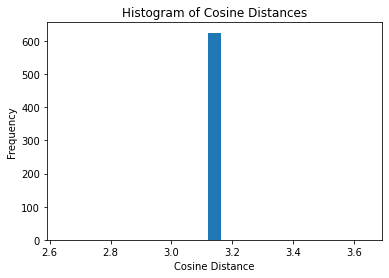

In [20]:
error_for_each_img = np.mean(cosine_distance, axis=1)
plt.hist(cosine_distance.flatten(), bins=25)
plt.title('Histogram of Cosine Distances')
plt.xlabel('Cosine Distance')
plt.ylabel('Frequency')
plt.show();